In [1]:
import pandas as pd

data = pd.read_csv('bank.csv')

data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [3]:
# Identify categorical and numerical columns more explicitly
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
numerical_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values for numerical data
    ('scaler', StandardScaler())  # Normalize numerical features
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handle missing values for categorical data
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Convert categorical data
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Split data into features and target label
X = data.drop(['deposit'], axis=1)
y = data['deposit']

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create and fit the preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X_train_prepared = preprocessing_pipeline.fit_transform(X_train)
X_test_prepared = preprocessing_pipeline.transform(X_test)

X_train_prepared.shape, X_test_prepared.shape


((8929, 51), (2233, 51))

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [5]:
# Define machine learning models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "SVM": SVC(random_state=0),
    "Random Forest": RandomForestClassifier(random_state=0),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=0)
}

# Create pipelines for each model
pipelines = {name: Pipeline(steps=[('preprocessor', preprocessor),
                                   ('classifier', model)]) for name, model in models.items()}

# Train and evaluate each model using cross-validation
model_scores = {}
for name, pipeline in pipelines.items():
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    model_scores[name] = scores

model_scores

{'Decision Tree': array([0.78947368, 0.79395297, 0.76987682, 0.79787234, 0.77030812]),
 'SVM': array([0.8549832 , 0.84490482, 0.84994401, 0.85778275, 0.84929972]),
 'Random Forest': array([0.85274356, 0.84490482, 0.84658455, 0.86954087, 0.84201681]),
 'Logistic Regression': array([0.82866741, 0.82642777, 0.82418813, 0.82586786, 0.82857143])}

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [7]:
# Function to evaluate the model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, pos_label='yes'),
        "Recall": recall_score(y_test, y_pred, pos_label='yes'),
        "F1 Score": f1_score(y_test, y_pred, pos_label='yes'),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }
    if 'predict_proba' in dir(model):
        y_scores = model.predict_proba(X_test)[:, 1]  # score for the positive class
        fpr, tpr, _ = roc_curve(y_test, y_scores, pos_label='yes')
        roc_auc = roc_auc_score(y_test, y_scores)
        scores['ROC AUC'] = roc_auc
        scores['ROC Curve'] = (fpr, tpr)
    return scores

# Adjust SVM configuration to enable probability estimates
models['SVM'] = SVC(probability=True, random_state=0)

# Update pipelines to include the new SVM configuration
pipelines['SVM'] = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', models['SVM'])])

# Re-evaluate models
results = {}
for name, pipeline in pipelines.items():
    results[name] = evaluate_model(pipeline, X_train, X_test, y_train, y_test)

C:\Users\PC\AppData\Local\Temp\ipykernel_19672\3844137602.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['', 'No', 'Yes'])
C:\Users\PC\AppData\Local\Temp\ipykernel_19672\3844137602.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['', 'No', 'Yes'])
C:\Users\PC\AppData\Local\Temp\ipykernel_19672\3844137602.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['', 'No', 'Yes'])
C:\Users\PC\AppData\Local\Temp\ipykernel_19672\3844137602.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['', 'No', 'Yes'])
C:\Users\PC\AppData\Local\Temp\ipykernel_19672\3844137602.py:11: Use

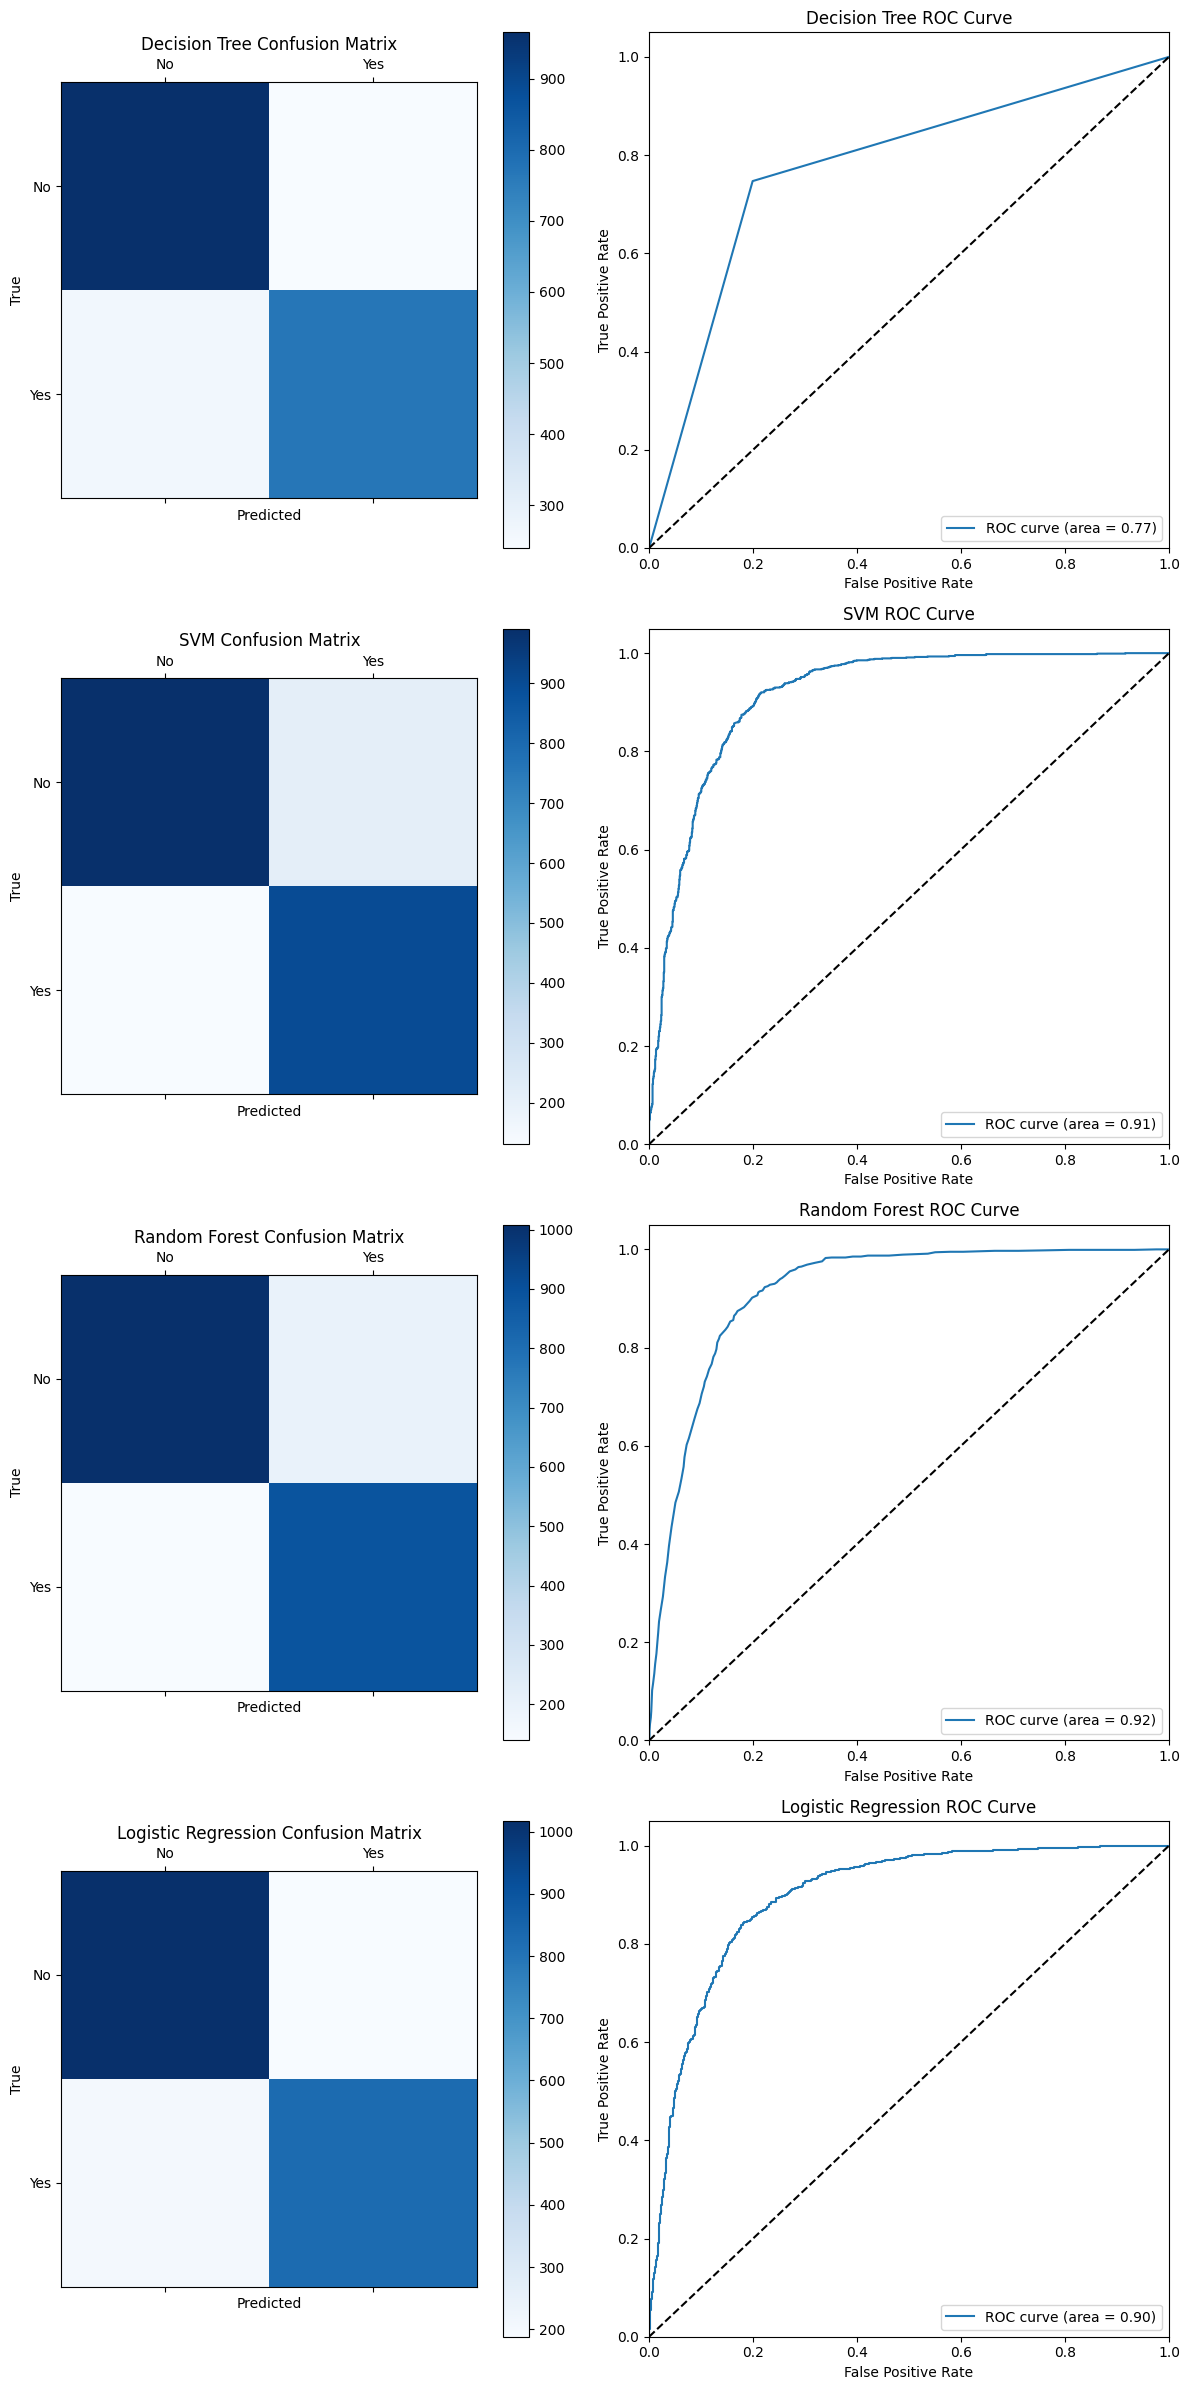

In [8]:
# Plotting Confusion Matrix and ROC Curve for each model
fig, axes = plt.subplots(nrows=len(models), ncols=2, figsize=(12, 24))
for idx, (name, result) in enumerate(results.items()):
    ax = axes[idx, 0]
    cm = result['Confusion Matrix']
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    plt.colorbar(cax, ax=ax)
    ax.set_title(f"{name} Confusion Matrix")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticklabels(['', 'No', 'Yes'])
    ax.set_yticklabels(['', 'No', 'Yes'])
    
    if 'ROC Curve' in result:
        fpr, tpr = result['ROC Curve']
        ax = axes[idx, 1]
        ax.plot(fpr, tpr, label=f'ROC curve (area = {result["ROC AUC"]:.2f})')
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'{name} ROC Curve')
        ax.legend(loc="lower right")

plt.tight_layout()
plt.show()


In [9]:
results

{'Decision Tree': {'Accuracy': 0.7760859829825347,
  'Precision': 0.7619047619047619,
  'Recall': 0.7470817120622568,
  'F1 Score': 0.7544204322200393,
  'Confusion Matrix': array([[965, 240],
         [260, 768]]),
  'ROC AUC': np.float64(0.7739557937904645),
  'ROC Curve': (array([0.        , 0.19917012, 1.        ]),
   array([0.        , 0.74708171, 1.        ]))},
 'SVM': {'Accuracy': 0.8454993282579489,
  'Precision': 0.8073807380738074,
  'Recall': 0.872568093385214,
  'F1 Score': 0.8387096774193549,
  'Confusion Matrix': array([[991, 214],
         [131, 897]]),
  'ROC AUC': np.float64(0.9145841742415681),
  'ROC Curve': (array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.29875519e-04,
          8.29875519e-04, 1.65975104e-03, 1.65975104e-03, 2.48962656e-03,
          2.48962656e-03, 3.31950207e-03, 3.31950207e-03, 4.14937759e-03,
          4.14937759e-03, 4.97925311e-03, 4.97925311e-03, 5.80912863e-03,
          5.80912863e-03, 6.63900415e-03, 6.63900415e-03, 7.46887967e

In [10]:
rf_pipeline = pipelines['Random Forest']

# Fit the Random Forest model on the entire training set and find feature importances
rf_pipeline.fit(X_train, y_train)

# Properly extracting feature names from the ColumnTransformer, including transformed categorical variables
transformed_features = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Use the feature importances directly from the Random Forest model
feature_importances = rf_pipeline.named_steps['classifier'].feature_importances_

# Create a DataFrame linking features with their importances
direct_feature_importance = pd.DataFrame({
    "feature": transformed_features,
    "importance": feature_importances
})

# Sort features by importance
sorted_direct_features = direct_feature_importance.sort_values(by="importance", ascending=False).head(10)
sorted_direct_features



,feature,importance
3,num__duration,0.328113
1,num__balance,0.077666
0,num__age,0.071704
2,num__day,0.064865
4,num__campaign,0.034510
5,num__pdays,0.033242
49,cat__poutcome_success,0.031807
34,cat__contact_unknown,0.024574
6,num__previous,0.020112
29,cat__housing_yes,0.018785


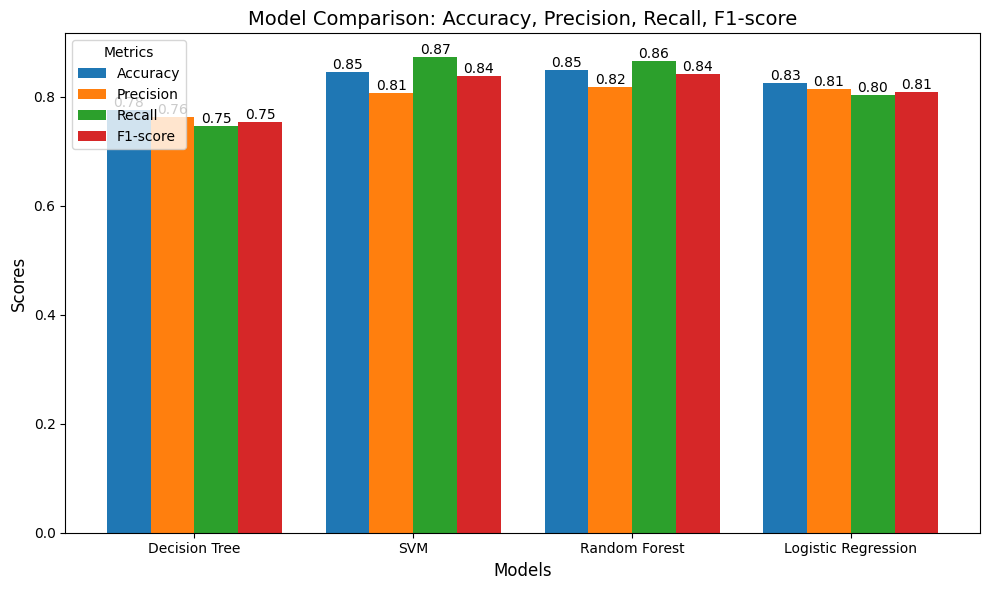

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode the target variable (deposit) into numerical values (0 and 1)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# create and retrain models with the encoded target variable
trained_models = {name: pipeline.fit(X_train, y_train_encoded) for name, pipeline in pipelines.items()}
y_preds = {name: model.predict(X_test) for name, model in trained_models.items()}

# Calculate metrics for each model: Accuracy, Precision, Recall, F1-score
metrics = {}
for model_name, y_pred in y_preds.items():
    accuracy = np.mean(y_test_encoded == y_pred)
    precision = precision_score(y_test_encoded, y_pred)
    recall = recall_score(y_test_encoded, y_pred)
    f1 = f1_score(y_test_encoded, y_pred)
    metrics[model_name] = [accuracy, precision, recall, f1]

# Prepare data for the plot
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-score']
metrics_values = np.array(list(metrics.values()))

# Create the grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.2  # Width of the bars
x = np.arange(len(models))  # x locations for the models

# Plotting each metric
for i, metric_name in enumerate(metrics_names):
    bars = ax.bar(x + i * width, metrics_values[:, i], width, label=metric_name)

    # Adding value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', 
                ha='center', va='bottom', fontsize=10)

# Adding labels and title
ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)
ax.set_title('Model Comparison: Accuracy, Precision, Recall, F1-score', fontsize=14)
ax.set_xticks(x + width * 1.5)  # Positioning the model labels
ax.set_xticklabels(models)

# Adding a legend
ax.legend(title="Metrics", loc="upper left")

# Show the plot
plt.tight_layout()
plt.show()
